In [29]:
import os
import numpy as np
import time
import copy
import sys
import scipy.io

import matplotlib
import matplotlib.pyplot as plt

ang_2_bohr = 1.0/0.52917721067
hart_2_ev = 27.21138602

import cp2k_utilities as cu

In [30]:
folder = "/home/kristjan/local_work/12mol_7agnr/"

file_cp2k_inp = folder + "cp2k.inp"
file_cp2k_out = folder + "cp2k.out"

file_basis_set = folder + "BR"
file_xyz = folder + "12mol_7agnr_opt.xyz"

file_restart = folder + "PROJ-RESTART.wfn"

file_hartree = folder + "PROJ-HART-v_hartree-1_0.cube"

In [31]:
emin = -2.0 # eV
emax =  2.0 # eV

In [32]:
time1 = time.time()
elem_basis_names, cell = cu.read_cp2k_input(file_cp2k_inp)
print("Read cp2k input: %.3f" % (time.time()-time1))

time1 = time.time()
fermi = cu.read_fermi_from_cp2k_out(file_cp2k_out)
print("Read cp2k out: %.3f" % (time.time()-time1))

time1 = time.time()
at_positions, at_elems = cu.read_atoms(file_xyz)
print("Read xyz: %.3f" % (time.time()-time1))

time1 = time.time()
basis_sets = cu.read_basis_functions(file_basis_set, elem_basis_names)
print("Read basis sets: %.3f" % (time.time()-time1))

# RESTART FILE

time1 = time.time()
morb_composition, morb_energies, morb_occs, ref_energy = cu.load_restart_wfn_file(file_restart, emin, emax, fermi)
print("Found %d orbitals" % len(morb_energies))
print("Read restart: %.3f" % (time.time()-time1))

# HARTREE CUBE

time1 = time.time()
hart_cube_data = cu.read_cube_file(file_hartree)
hart_cube = hart_cube_data[-1]
hart_cell = hart_cube_data[5]
print("Read hartree: %.3f" % (time.time()-time1))

Read cp2k input: 0.001
Read cp2k out: 0.008
Read xyz: 0.009
Read basis sets: 0.004
First molecular index in energy range:  660
Found 76 orbitals
Read restart: 1.465
Read hartree: 28.522


# Plane definition

In [53]:
# Define the plane

#height = 2.5 # Plane distance in z direction from topmost atom; angstroms

height = 2.5

#carb_positions = at_positions[np.array(at_elems)[:, 0] == 'C']
plane_z = np.max(at_positions[:, 2]) + height*ang_2_bohr # in BOHR!

# Use same grid as in the hartree cube file
cell_n = np.shape(hart_cube)

# CELL AND DV IN BOHR
dv = cell[0:2]/cell_n[0:2]
x_arr = np.arange(0, cell[0], dv[0])
y_arr = np.arange(0, cell[1], dv[1])

min: 4.4532; max: 5.0990; avg: 4.7294 (eV)
(comparison w Leo) min: 0.013510; max: 0.037243; avg: 0.023661 (au)


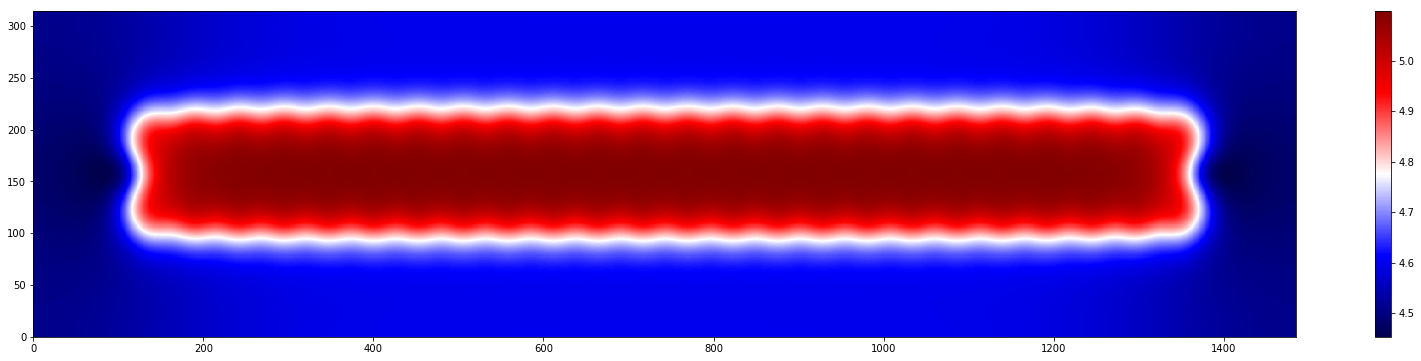

In [54]:
# Hartree potential on the plane

plane_index = int(np.round(plane_z/ang_2_bohr/hart_cell[2, 2]*np.shape(hart_cube)[2]))
hart_plane = hart_cube[:, :, plane_index] - ref_energy/hart_2_ev

print("min: %.4f; max: %.4f; avg: %.4f (eV)" % (np.min(hart_plane)*hart_2_ev,
                                                np.max(hart_plane)*hart_2_ev,
                                                np.mean(hart_plane)*hart_2_ev))

print("(comparison w Leo) min: %.6f; max: %.6f; avg: %.6f (au)" % (np.min(hart_plane)+ref_energy/hart_2_ev,
                                                                   np.max(hart_plane)+ref_energy/hart_2_ev,
                                                                   np.mean(hart_plane)+ref_energy/hart_2_ev))
fig_size = 6
plt.figure(figsize=(fig_size*hart_plane.shape[0]/hart_plane.shape[1], fig_size))
plt.pcolormesh(hart_plane.T*hart_2_ev, cmap='seismic')
plt.colorbar()
plt.show()

simple_hartree_avg = np.mean(hart_plane)

# Molecular orbitals on the plane

In [55]:
# Calculate molecular orbitals on the plane

morb_planes = cu.calc_morb_planes(cell[0:2], cell_n[0:2], plane_z,
                                  at_positions, at_elems,
                                  basis_sets, morb_composition)

Main plane:    [ 228.65686118   49.13287926] (1485, 315)
Local plane:  [ 18.89726125  18.89726125] [123 122]
---- Setup: 0.0257
---- Radial calc time : 6.928456
---- Spherical calc time : 0.281929
---- Loc -> glob time : 46.440982
---- Total time: 55.2806


In [56]:
i_homo = 0

for i, en in enumerate(morb_energies):
    if en > 0.0:
        i_homo = i - 1
        break
    if np.abs(en) < 1e-6:
        i_homo = i
print(i_homo)

63


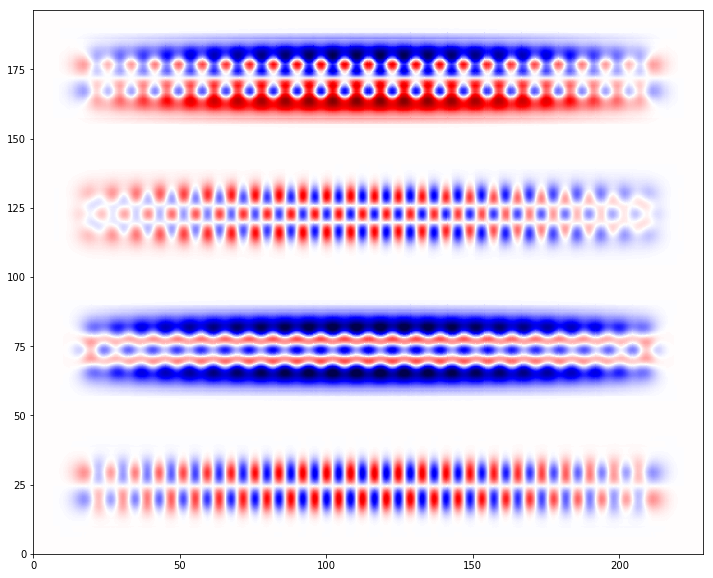

In [60]:
select = [i_homo - 5, i_homo, i_homo+1, i_homo + 4]

sel_morbs = np.zeros((cell_n[0], 4*cell_n[1]))

for i, i_mo in enumerate(select):
    sel_morbs[:, i*cell_n[1]:(i+1)*cell_n[1]] = morb_planes[i_mo]
    
y_arr_inc = np.arange(0, 4*cell[1], dv[1])

x_grid_inc, y_grid_inc = np.meshgrid(x_arr, y_arr_inc, indexing='ij')

max_val = np.max(sel_morbs)

plt.figure(figsize=(12, int(cell[1]/cell[0]*12*4)))
plt.pcolormesh(x_grid_inc, y_grid_inc, sel_morbs, vmax=max_val, vmin=-max_val, cmap='seismic') # seismic bwr
#plt.axvline(np.max(x_grid_inc)/2)
plt.show()

# STM plane

In [61]:
# Define the plane

stm_height = 4.0 # Plane distance in z direction from topmost atom; angstroms

stm_plane_z = np.max(at_positions[:, 2]) + stm_height*ang_2_bohr # in BOHR!

# Use same step and cell_n as before

# Extrapolation

In [62]:
def extrapolate_morbs(use_weighted_avg):
    # NB: everything in hartree units!
    extrap_planes = []
    time1 = time.time()
    for morb_index in range(len(morb_planes)):
        
        if use_weighted_avg:
            # weigh the hartree potential by the molecular orbital
            density_plane = morb_planes[morb_index]**2
            density_plane /= np.sum(density_plane)
            weighted_hartree = hart_plane * density_plane
            hartree_avg = np.sum(weighted_hartree)
        else:
            hartree_avg = simple_hartree_avg

        energy = morb_energies[morb_index]/hart_2_ev
        if energy > hartree_avg:
            print("Warning: unbound state, can't extrapolate! index: %d. Exiting." % morb_index)
            break

        fourier = np.fft.rfft2(morb_planes[morb_index])
        # NB: rfft2 takes REAL fourier transform over last (y) axis and COMPLEX over other (x) axes
        # dv in BOHR, so k is in 1/bohr
        kx_arr = 2*np.pi*np.fft.fftfreq(morb_planes[morb_index].shape[0], dv[0])
        ky_arr = 2*np.pi*np.fft.rfftfreq(morb_planes[morb_index].shape[1], dv[1])

        kx_grid, ky_grid = np.meshgrid(kx_arr, ky_arr, indexing='ij')

        delta_z = (stm_plane_z - plane_z)

        prefactors = np.exp(-np.sqrt(kx_grid**2 + ky_grid**2 - 2*(energy - hartree_avg))*delta_z)
        extrap_plane = np.fft.irfft2(fourier*prefactors, morb_planes[morb_index].shape)
        extrap_planes.append(extrap_plane)
    print("Time: %.3f s"%(time.time()-time1))
    return extrap_planes

extrap_planes_wavg = extrapolate_morbs(True)
extrap_planes_simp = extrapolate_morbs(False)

Time: 3.228 s
Time: 3.405 s


In [63]:
# Orbitals at stm distance without extrapolation
noextr_morb_planes = cu.calc_morb_planes(cell[0:2], cell_n[0:2], stm_plane_z,
                                  at_positions, at_elems,
                                  basis_sets, morb_composition)

Main plane:    [ 228.65686118   49.13287926] (1485, 315)
Local plane:  [ 18.89726125  18.89726125] [123 122]
---- Setup: 0.0234
---- Radial calc time : 6.483203
---- Spherical calc time : 0.255480
---- Loc -> glob time : 44.196969
---- Total time: 52.4405


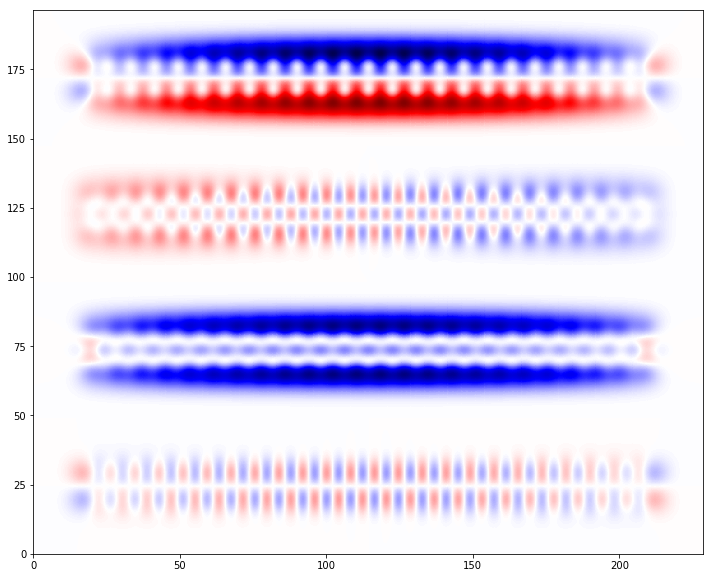

In [70]:
select = [i_homo - 5, i_homo, i_homo+1, i_homo + 4]

sel_morbs = np.zeros((cell_n[0], 4*cell_n[1]))

for i, i_mo in enumerate(select):
    # morb_planes noextr_morb_planes extrap_planes_simp extrap_planes_wavg
    sel_morbs[:, i*cell_n[1]:(i+1)*cell_n[1]] = extrap_planes_wavg[i_mo]
    
y_arr_inc = np.arange(0, 4*cell[1], dv[1])

x_grid_inc, y_grid_inc = np.meshgrid(x_arr, y_arr_inc, indexing='ij')

max_val = np.max(sel_morbs)

plt.figure(figsize=(12, int(cell[1]/cell[0]*12*4)))
plt.pcolormesh(x_grid_inc, y_grid_inc, sel_morbs, vmax=max_val, vmin=-max_val, cmap='seismic') # seismic bwr
#plt.axvline(np.max(x_grid_inc)/2)
plt.show()

# Validating against CUBE files

In [86]:
cube_file = "/home/kristjan/local_work/12mol_7agnr/morbs/PROJ-WFN_00724_1-1_0.cube"

time1 = time.time()
cube_data = cu.read_cube_file(cube_file)
print("Loading cube file: %.2f s" % (time.time()-time1))

wfn_data = cube_data[-1]
cube_shape = cube_data[4]
cube_cell = cube_data[5]
cube_dz = cube_cell[2, 2]/cube_shape[2]
cube_plane_index = int(np.round(plane_z/ang_2_bohr/cube_dz))

Loading cube file: 24.29 s


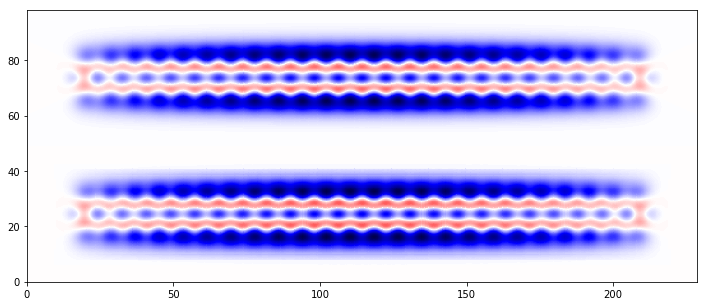

In [89]:
sel_morbs = np.zeros((cell_n[0], 2*cell_n[1]))

sel_morbs[:, 0:cell_n[1]] = morb_planes[i_homo]
sel_morbs[:, cell_n[1]:] = wfn_data[:, :, cube_plane_index]

y_arr_inc = np.arange(0, 2*cell[1], dv[1])
x_grid_inc, y_grid_inc = np.meshgrid(x_arr, y_arr_inc, indexing='ij')

max_abs = np.max(np.abs(sel_morbs))

plt.figure(figsize=(12, int(cell[1]/cell[0]*12*2)))
plt.pcolormesh(x_grid_inc, y_grid_inc, sel_morbs, cmap='seismic', vmax=max_abs, vmin=-max_abs)
#plt.colorbar()
plt.show()